In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.densenet import DenseNet121,preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortexNoLegend"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Creating base_model
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = DenseNet121(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [6]:
print("Extracting bottleneck features from convolutional layers ...")
bnfeatures = base_model.predict(X)

Extracting bottleneck features from convolutional layers ...


In [7]:
bnfeatures.shape

(10136, 1, 1, 1024)

In [8]:
bnfeatures = np.reshape(bnfeatures,(bnfeatures.shape[0],-1))

In [9]:
bnfeatures.shape

(10136, 1024)

In [ ]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True, random_state=1)

In [ ]:
# Training top_model
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-8, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, verbose=10, n_jobs=-1)
top_model.fit(bnfeatures,y)  # Training 

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-07, C=0.01 .............................................
[CV] gamma=1e-07, C=0.01 .............................................
[CV] gamma=1e-07, C=0.01 .............................................
[CV] gamma=1e-

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 10.1min


[CV] .............. gamma=1e-08, C=0.01, score=0.138889, total= 6.1min
[CV] gamma=1e-06, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.138477, total= 6.1min
[CV] gamma=1e-06, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.137795, total= 6.1min
[CV] gamma=1e-06, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.137695, total= 6.1min
[CV] gamma=1e-06, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.138751, total= 6.1min
[CV] gamma=1e-05, C=0.01 .............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.137695, total= 6.1min
[CV] gamma=1e-05, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.137255, total= 6.1min
[CV] gamma=1e-05, C=0.01 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 10.7min


[CV] .............. gamma=1e-07, C=0.01, score=0.136986, total= 6.5min
[CV] gamma=1e-05, C=0.01 .............................................
[CV] .............. gamma=1e-07, C=0.01, score=0.137795, total= 6.5min
[CV] gamma=1e-05, C=0.01 .............................................
[CV] .............. gamma=1e-07, C=0.01, score=0.137695, total= 6.5min
[CV] gamma=1e-05, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.139442, total= 6.5min
[CV] gamma=0.0001, C=0.01 ............................................
[CV] .............. gamma=1e-07, C=0.01, score=0.138889, total= 6.5min
[CV] gamma=0.0001, C=0.01 ............................................
[CV] .............. gamma=1e-07, C=0.01, score=0.137255, total= 6.5min
[CV] gamma=0.0001, C=0.01 ............................................
[CV] .............. gamma=1e-07, C=0.01, score=0.138751, total= 6.5min
[CV] gamma=0.0001, C=0.01 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 10.8min


[CV] .............. gamma=1e-06, C=0.01, score=0.137795, total= 6.1min
[CV] gamma=0.0001, C=0.01 ............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.138889, total= 6.1min
[CV] gamma=0.0001, C=0.01 ............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.138477, total= 6.1min
[CV] gamma=0.001, C=0.01 .............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.138751, total= 6.1min
[CV] gamma=0.001, C=0.01 .............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.139165, total= 6.1min
[CV] gamma=0.001, C=0.01 .............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.139442, total= 6.1min
[CV] gamma=0.001, C=0.01 .............................................
[CV] .............. gamma=1e-05, C=0.01, score=0.137695, total= 6.1min
[CV] gamma=0.001, C=0.01 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 21.4min


[CV] .............. gamma=1e-05, C=0.01, score=0.139165, total= 6.5min
[CV] gamma=0.01, C=0.01 ..............................................
[CV] .............. gamma=1e-05, C=0.01, score=0.138889, total= 6.5min
[CV] gamma=0.01, C=0.01 ..............................................
[CV] .............. gamma=1e-05, C=0.01, score=0.139442, total= 6.5min
[CV] gamma=0.01, C=0.01 ..............................................
[CV] ............. gamma=0.0001, C=0.01, score=0.136986, total= 6.6min
[CV] gamma=0.01, C=0.01 ..............................................
[CV] ............. gamma=0.0001, C=0.01, score=0.137795, total= 6.6min
[CV] gamma=0.01, C=0.01 ..............................................
[CV] ............. gamma=0.0001, C=0.01, score=0.137255, total= 6.6min
[CV] gamma=0.01, C=0.01 ..............................................
[CV] ............. gamma=0.0001, C=0.01, score=0.137795, total= 6.6min
[CV] gamma=0.01, C=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 30.2min


[CV] .............. gamma=0.001, C=0.01, score=0.339216, total= 6.1min
[CV] gamma=0.1, C=0.01 ...............................................
[CV] .............. gamma=0.001, C=0.01, score=0.341535, total= 6.1min
[CV] gamma=0.1, C=0.01 ...............................................
[CV] .............. gamma=0.001, C=0.01, score=0.339567, total= 6.1min
[CV] gamma=0.1, C=0.01 ...............................................
[CV] .............. gamma=0.001, C=0.01, score=0.339941, total= 6.1min
[CV] gamma=0.1, C=0.01 ...............................................
[CV] .............. gamma=0.001, C=0.01, score=0.341246, total= 6.1min
[CV] gamma=0.1, C=0.01 ...............................................
[CV] .............. gamma=0.001, C=0.01, score=0.342262, total= 6.1min
[CV] gamma=0.1, C=0.01 ...............................................
[CV] .............. gamma=0.001, C=0.01, score=0.341948, total= 6.1min
[CV] gamma=1.0, C=0.01 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed: 30.8min


[CV] ............... gamma=0.01, C=0.01, score=0.439961, total= 5.6min
[CV] gamma=1.0, C=0.01 ...............................................
[CV] ............... gamma=0.01, C=0.01, score=0.458870, total= 5.6min
[CV] gamma=10.0, C=0.01 ..............................................
[CV] ............... gamma=0.01, C=0.01, score=0.458333, total= 5.6min
[CV] gamma=10.0, C=0.01 ..............................................
[CV] ............... gamma=0.01, C=0.01, score=0.461233, total= 5.6min
[CV] gamma=10.0, C=0.01 ..............................................
[CV] ............... gamma=0.01, C=0.01, score=0.442231, total= 5.6min
[CV] gamma=10.0, C=0.01 ..............................................
[CV] ................ gamma=0.1, C=0.01, score=0.325832, total= 7.9min
[CV] gamma=10.0, C=0.01 ..............................................
[CV] ................ gamma=0.1, C=0.01, score=0.353516, total= 8.0min
[CV] gamma=10.0, C=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 41.7min


[CV] ................ gamma=1.0, C=0.01, score=0.213867, total= 8.5min
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] ................ gamma=1.0, C=0.01, score=0.203523, total= 8.5min
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] ................ gamma=1.0, C=0.01, score=0.212598, total= 8.5min
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] ................ gamma=1.0, C=0.01, score=0.191176, total= 8.6min
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] ................ gamma=1.0, C=0.01, score=0.211614, total= 9.1min
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] ................ gamma=1.0, C=0.01, score=0.211672, total= 9.1min
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] ................ gamma=1.0, C=0.01, score=0.213294, total= 9.1min
[CV] gamma=1e-07, C=0.1 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 51.7min


[CV] ............... gamma=1e-08, C=0.1, score=0.137255, total= 6.0min
[CV] gamma=1e-06, C=0.1 ..............................................
[CV] ............... gamma=1e-08, C=0.1, score=0.137795, total= 6.0min
[CV] gamma=1e-06, C=0.1 ..............................................
[CV] ............... gamma=1e-08, C=0.1, score=0.136986, total= 6.1min
[CV] gamma=1e-06, C=0.1 ..............................................
[CV] ............... gamma=1e-08, C=0.1, score=0.137795, total= 6.0min
[CV] gamma=1e-06, C=0.1 ..............................................
[CV] ............... gamma=1e-08, C=0.1, score=0.138751, total= 6.0min
[CV] gamma=1e-06, C=0.1 ..............................................
[CV] ............... gamma=1e-08, C=0.1, score=0.138889, total= 6.0min
[CV] gamma=1e-06, C=0.1 ..............................................
[CV] ............... gamma=1e-08, C=0.1, score=0.138477, total= 6.1min
[CV] gamma=1e-06, C=0.1 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 54.8min


[CV] ............... gamma=1e-07, C=0.1, score=0.137795, total= 6.4min
[CV] gamma=1e-05, C=0.1 ..............................................
[CV] ............... gamma=1e-07, C=0.1, score=0.138477, total= 6.4min
[CV] gamma=1e-05, C=0.1 ..............................................
[CV] ............... gamma=1e-07, C=0.1, score=0.138889, total= 6.4min
[CV] gamma=0.0001, C=0.1 .............................................
[CV] ............... gamma=1e-07, C=0.1, score=0.138751, total= 6.5min
[CV] gamma=0.0001, C=0.1 .............................................
[CV] ............... gamma=1e-07, C=0.1, score=0.139165, total= 6.4min
[CV] gamma=0.0001, C=0.1 .............................................
[CV] ............... gamma=1e-07, C=0.1, score=0.139442, total= 6.4min
[CV] gamma=0.0001, C=0.1 .............................................
[CV] ............... gamma=1e-06, C=0.1, score=0.137695, total= 6.1min
[CV] gamma=0.0001, C=0.1 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 65.3min


[CV] .............. gamma=0.0001, C=0.1, score=0.385519, total= 6.3min
[CV] gamma=0.001, C=0.1 ..............................................
[CV] ............... gamma=1e-05, C=0.1, score=0.137255, total= 6.6min
[CV] gamma=0.001, C=0.1 ..............................................
[CV] ............... gamma=1e-05, C=0.1, score=0.138751, total= 6.6min
[CV] gamma=0.001, C=0.1 ..............................................
[CV] ............... gamma=1e-05, C=0.1, score=0.137795, total= 6.7min
[CV] gamma=0.01, C=0.1 ...............................................
[CV] ............... gamma=1e-05, C=0.1, score=0.138477, total= 6.6min
[CV] gamma=0.01, C=0.1 ...............................................
[CV] ............... gamma=1e-05, C=0.1, score=0.137795, total= 6.6min
[CV] gamma=0.01, C=0.1 ...............................................
[CV] ............... gamma=1e-05, C=0.1, score=0.138889, total= 6.6min
[CV] gamma=0.01, C=0.1 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 70.8min


[CV] ................ gamma=0.01, C=0.1, score=0.832839, total= 2.6min
[CV] gamma=0.1, C=0.1 ................................................
[CV] ............... gamma=0.001, C=0.1, score=0.758858, total= 3.2min
[CV] gamma=0.1, C=0.1 ................................................
[CV] ............... gamma=0.001, C=0.1, score=0.760827, total= 3.2min
[CV] gamma=0.1, C=0.1 ................................................
[CV] ............... gamma=0.001, C=0.1, score=0.784372, total= 3.2min
[CV] gamma=0.1, C=0.1 ................................................
[CV] .............. gamma=0.0001, C=0.1, score=0.386811, total= 6.0min
[CV] gamma=1.0, C=0.1 ................................................
[CV] .............. gamma=0.0001, C=0.1, score=0.388724, total= 5.9min
[CV] gamma=1.0, C=0.1 ................................................
[CV] .............. gamma=0.0001, C=0.1, score=0.388889, total= 6.0min
[CV] gamma=1.0, C=0.1 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 81.0min


[CV] gamma=10.0, C=0.1 ...............................................
[CV] ................. gamma=0.1, C=0.1, score=0.462818, total= 7.2min
[CV] gamma=10.0, C=0.1 ...............................................
[CV] ................. gamma=0.1, C=0.1, score=0.449020, total= 7.2min
[CV] gamma=10.0, C=0.1 ...............................................
[CV] ................. gamma=0.1, C=0.1, score=0.447211, total= 6.8min
[CV] gamma=1e-08, C=1.0 ..............................................
[CV] ................. gamma=0.1, C=0.1, score=0.440945, total= 7.2min
[CV] gamma=1e-08, C=1.0 ..............................................
[CV] ................. gamma=0.1, C=0.1, score=0.450942, total= 7.2min
[CV] gamma=1e-08, C=1.0 ..............................................
[CV] ................. gamma=0.1, C=0.1, score=0.435213, total= 7.2min
[CV] gamma=1e-08, C=1.0 ..............................................
[CV] ................. gamma=1.0, C=0.1, score=0.312500, total= 8.2min
[CV] g

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 86.7min


[CV] ............... gamma=1e-08, C=1.0, score=0.137695, total= 6.1min
[CV] gamma=1e-07, C=1.0 ..............................................
[CV] ............... gamma=1e-08, C=1.0, score=0.136986, total= 6.4min
[CV] gamma=1e-07, C=1.0 ..............................................
[CV] ............... gamma=1e-08, C=1.0, score=0.137795, total= 6.4min
[CV] gamma=1e-06, C=1.0 ..............................................
[CV] ............... gamma=1e-08, C=1.0, score=0.137255, total= 6.4min
[CV] gamma=1e-06, C=1.0 ..............................................
[CV] ................ gamma=10.0, C=0.1, score=0.235236, total= 8.6min
[CV] gamma=1e-06, C=1.0 ..............................................
[CV] ................ gamma=10.0, C=0.1, score=0.240356, total= 8.5min
[CV] gamma=1e-06, C=1.0 ..............................................
[CV] ................ gamma=10.0, C=0.1, score=0.241824, total= 8.5min
[CV] gamma=1e-06, C=1.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 97.0min


[CV] ............... gamma=1e-07, C=1.0, score=0.138751, total= 6.4min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ............... gamma=1e-07, C=1.0, score=0.139165, total= 6.1min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ............... gamma=1e-07, C=1.0, score=0.139442, total= 6.4min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ............... gamma=1e-06, C=1.0, score=0.137695, total= 6.6min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ............... gamma=1e-06, C=1.0, score=0.136986, total= 6.6min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ............... gamma=1e-06, C=1.0, score=0.137255, total= 6.2min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] .............. gamma=0.0001, C=1.0, score=0.780273, total= 3.1min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 105.7min


[CV] ............... gamma=1e-05, C=1.0, score=0.392644, total= 5.9min
[CV] gamma=0.01, C=1.0 ...............................................
[CV] ............... gamma=1e-05, C=1.0, score=0.394422, total= 6.0min
[CV] gamma=0.01, C=1.0 ...............................................
[CV] ............... gamma=0.001, C=1.0, score=0.886719, total= 1.4min
[CV] gamma=0.01, C=1.0 ...............................................
[CV] ............... gamma=0.001, C=1.0, score=0.893346, total= 1.4min
[CV] gamma=0.01, C=1.0 ...............................................
[CV] ............... gamma=0.001, C=1.0, score=0.883858, total= 1.4min
[CV] gamma=0.01, C=1.0 ...............................................
[CV] ............... gamma=0.001, C=1.0, score=0.870588, total= 1.4min
[CV] gamma=0.01, C=1.0 ...............................................
[CV] ............... gamma=0.001, C=1.0, score=0.890748, total= 1.4min
[CV] gamma=0.1, C=1.0 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed: 110.1min


[CV] ................ gamma=0.01, C=1.0, score=0.935707, total= 1.8min
[CV] gamma=1.0, C=1.0 ................................................
[CV] ................ gamma=0.01, C=1.0, score=0.944500, total= 1.9min
[CV] gamma=10.0, C=1.0 ...............................................
[CV] ................ gamma=0.01, C=1.0, score=0.935516, total= 1.8min
[CV] gamma=10.0, C=1.0 ...............................................
[CV] ................ gamma=0.01, C=1.0, score=0.940239, total= 1.8min
[CV] gamma=10.0, C=1.0 ...............................................
[CV] ................ gamma=0.01, C=1.0, score=0.944334, total= 1.8min
[CV] gamma=10.0, C=1.0 ...............................................
[CV] ................. gamma=0.1, C=1.0, score=0.636719, total= 6.5min
[CV] gamma=10.0, C=1.0 ...............................................
[CV] ................. gamma=0.1, C=1.0, score=0.637965, total= 6.5min
[CV] gamma=10.0, C=1.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 122.1min


[CV] ................ gamma=10.0, C=1.0, score=0.314453, total= 8.5min
[CV] gamma=1e-07, C=10.0 .............................................
[CV] ................ gamma=10.0, C=1.0, score=0.323875, total= 8.5min
[CV] gamma=1e-07, C=10.0 .............................................
[CV] ................ gamma=10.0, C=1.0, score=0.306102, total= 8.5min
[CV] gamma=1e-07, C=10.0 .............................................
[CV] ................ gamma=10.0, C=1.0, score=0.308824, total= 8.5min
[CV] gamma=1e-07, C=10.0 .............................................
[CV] ................ gamma=10.0, C=1.0, score=0.299213, total= 8.6min
[CV] gamma=1e-07, C=10.0 .............................................
[CV] .............. gamma=1e-08, C=10.0, score=0.137695, total= 6.3min
[CV] gamma=1e-07, C=10.0 .............................................
[CV] ................ gamma=10.0, C=1.0, score=0.312562, total= 8.6min
[CV] gamma=1e-06, C=10.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed: 133.2min


[CV] .............. gamma=1e-07, C=10.0, score=0.138889, total= 6.3min
[CV] gamma=0.0001, C=10.0 ............................................
[CV] ............. gamma=0.0001, C=10.0, score=0.879883, total= 1.3min
[CV] gamma=0.0001, C=10.0 ............................................
[CV] ............. gamma=0.0001, C=10.0, score=0.891389, total= 1.3min
[CV] gamma=0.0001, C=10.0 ............................................
[CV] .............. gamma=1e-05, C=10.0, score=0.781250, total= 3.0min
[CV] gamma=0.0001, C=10.0 ............................................
[CV] .............. gamma=1e-05, C=10.0, score=0.757843, total= 3.0min
[CV] gamma=0.0001, C=10.0 ............................................
[CV] .............. gamma=1e-05, C=10.0, score=0.786693, total= 3.2min
[CV] gamma=0.0001, C=10.0 ............................................
[CV] .............. gamma=1e-05, C=10.0, score=0.759843, total= 3.2min
[CV] gamma=0.0001, C=10.0 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed: 141.0min


[CV] ............. gamma=0.0001, C=10.0, score=0.891732, total= 1.3min
[CV] gamma=0.01, C=10.0 ..............................................
[CV] ............. gamma=0.0001, C=10.0, score=0.903066, total= 1.3min
[CV] gamma=0.01, C=10.0 ..............................................
[CV] .............. gamma=0.001, C=10.0, score=0.937378, total=  57.1s
[CV] gamma=0.1, C=10.0 ...............................................
[CV] .............. gamma=0.001, C=10.0, score=0.927734, total=  58.5s
[CV] gamma=0.1, C=10.0 ...............................................
[CV] .............. gamma=0.001, C=10.0, score=0.925490, total=  56.1s
[CV] gamma=0.1, C=10.0 ...............................................
[CV] .............. gamma=0.001, C=10.0, score=0.949803, total=  56.9s
[CV] gamma=0.1, C=10.0 ...............................................
[CV] ............. gamma=0.0001, C=10.0, score=0.889990, total= 1.4min
[CV] gamma=0.1, C=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed: 151.1min


[CV] ................ gamma=0.1, C=10.0, score=0.642928, total= 6.7min
[CV] gamma=10.0, C=10.0 ..............................................
[CV] ................ gamma=0.1, C=10.0, score=0.667659, total= 6.7min
[CV] gamma=10.0, C=10.0 ..............................................
[CV] ................ gamma=0.1, C=10.0, score=0.656556, total= 6.9min
[CV] gamma=10.0, C=10.0 ..............................................
[CV] ................ gamma=0.1, C=10.0, score=0.688867, total= 6.6min
[CV] gamma=1e-08, C=100.0 ............................................
[CV] ................ gamma=0.1, C=10.0, score=0.654528, total= 6.9min
[CV] gamma=1e-08, C=100.0 ............................................
[CV] ................ gamma=0.1, C=10.0, score=0.663033, total= 6.9min
[CV] gamma=1e-08, C=100.0 ............................................
[CV] ................ gamma=0.1, C=10.0, score=0.667331, total= 6.9min
[CV] gamma=1e-08, C=100.0 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 163.5min


[CV] ............... gamma=10.0, C=10.0, score=0.342942, total= 8.8min
[CV] gamma=1e-06, C=100.0 ............................................
[CV] ............... gamma=10.0, C=10.0, score=0.318725, total= 9.2min
[CV] gamma=1e-06, C=100.0 ............................................
[CV] ............. gamma=1e-08, C=100.0, score=0.137795, total= 6.5min
[CV] gamma=1e-06, C=100.0 ............................................
[CV] ............. gamma=1e-08, C=100.0, score=0.138477, total= 6.6min
[CV] gamma=1e-06, C=100.0 ............................................
[CV] ............. gamma=1e-08, C=100.0, score=0.138751, total= 6.6min
[CV] gamma=1e-05, C=100.0 ............................................
[CV] ............. gamma=1e-08, C=100.0, score=0.138889, total= 6.6min
[CV] gamma=1e-05, C=100.0 ............................................
[CV] ............. gamma=1e-08, C=100.0, score=0.139165, total= 6.2min
[CV] gamma=1e-05, C=100.0 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 433 tasks      | elapsed: 169.8min


[CV] ............. gamma=1e-05, C=100.0, score=0.886905, total= 1.3min
[CV] gamma=0.001, C=100.0 ............................................
[CV] ............. gamma=1e-05, C=100.0, score=0.900596, total= 1.3min
[CV] gamma=0.001, C=100.0 ............................................
[CV] ............ gamma=0.0001, C=100.0, score=0.926614, total=  56.4s
[CV] gamma=0.001, C=100.0 ............................................
[CV] ............. gamma=1e-05, C=100.0, score=0.887450, total= 1.4min
[CV] gamma=0.01, C=100.0 .............................................
[CV] ............. gamma=1e-06, C=100.0, score=0.766865, total= 3.2min
[CV] gamma=0.01, C=100.0 .............................................
[CV] ............ gamma=0.0001, C=100.0, score=0.924510, total=  55.1s
[CV] gamma=0.01, C=100.0 .............................................
[CV] ............ gamma=0.0001, C=100.0, score=0.925197, total=  53.0s
[CV] gamma=0.01, C=100.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed: 174.9min


[CV] .............. gamma=0.01, C=100.0, score=0.952756, total= 2.0min
[CV] gamma=1.0, C=100.0 ..............................................
[CV] .............. gamma=0.01, C=100.0, score=0.949455, total= 2.0min
[CV] gamma=1.0, C=100.0 ..............................................
[CV] .............. gamma=0.01, C=100.0, score=0.951195, total= 2.0min
[CV] gamma=10.0, C=100.0 .............................................
[CV] .............. gamma=0.01, C=100.0, score=0.944609, total= 2.0min
[CV] gamma=10.0, C=100.0 .............................................
[CV] .............. gamma=0.01, C=100.0, score=0.942460, total= 2.0min
[CV] gamma=10.0, C=100.0 .............................................
[CV] .............. gamma=0.01, C=100.0, score=0.955268, total= 2.1min
[CV] gamma=10.0, C=100.0 .............................................
[CV] ............... gamma=0.1, C=100.0, score=0.656556, total= 6.7min
[CV] gamma=10.0, C=100.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 497 tasks      | elapsed: 192.1min


[CV] ............ gamma=1e-08, C=1000.0, score=0.387795, total= 6.2min
[CV] gamma=1e-06, C=1000.0 ...........................................
[CV] ............ gamma=1e-07, C=1000.0, score=0.781250, total= 3.1min
[CV] gamma=1e-06, C=1000.0 ...........................................
[CV] ............ gamma=1e-07, C=1000.0, score=0.786693, total= 3.1min
[CV] gamma=1e-06, C=1000.0 ...........................................
[CV] .............. gamma=10.0, C=100.0, score=0.307087, total= 8.8min
[CV] gamma=1e-06, C=1000.0 ...........................................
[CV] ............ gamma=1e-07, C=1000.0, score=0.757843, total= 3.1min
[CV] gamma=1e-06, C=1000.0 ...........................................
[CV] .............. gamma=10.0, C=100.0, score=0.320475, total= 8.7min
[CV] gamma=1e-06, C=1000.0 ...........................................
[CV] ............ gamma=1e-07, C=1000.0, score=0.764764, total= 3.0min
[CV] gamma=1e-06, C=1000.0 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed: 196.9min


[CV] ............ gamma=1e-05, C=1000.0, score=0.942517, total=  56.2s
[CV] gamma=0.001, C=1000.0 ...........................................
[CV] ............ gamma=1e-06, C=1000.0, score=0.903066, total= 1.4min
[CV] gamma=0.001, C=1000.0 ...........................................
[CV] ............ gamma=1e-06, C=1000.0, score=0.900596, total= 1.4min
[CV] gamma=0.001, C=1000.0 ...........................................
[CV] ............ gamma=1e-05, C=1000.0, score=0.927579, total=  56.6s
[CV] gamma=0.001, C=1000.0 ...........................................
[CV] ............ gamma=1e-06, C=1000.0, score=0.887450, total= 1.4min
[CV] gamma=0.001, C=1000.0 ...........................................
[CV] ............ gamma=1e-07, C=1000.0, score=0.787276, total= 3.0min
[CV] gamma=0.01, C=1000.0 ............................................
[CV] ............ gamma=1e-05, C=1000.0, score=0.937376, total=  57.9s
[CV] gamma=0.01, C=1000.0 ............................................
[CV] .

In [16]:
top_model.cv_results_

{'mean_fit_time': array([341.3911212 , 360.59257517, 340.77422857, 349.04217575,
        366.08849566, 339.49446075, 312.43524256, 430.93059006,
        506.08127353, 512.68890004, 340.5201658 , 356.46936951,
        341.53120475, 365.19302924, 339.46680365, 175.32736621,
        139.81359951, 401.42499433, 477.69370837, 500.26823802,
        345.88684859, 349.44229372, 354.09963765, 340.97320845,
        166.14758761,  72.56150258, 100.43282518, 384.78253357,
        476.13090613, 493.3113029 , 350.4035691 , 355.87031825,
        340.53104787, 165.67446916,  68.75735257,  47.68327026,
        107.62555945, 386.72581189, 486.99019055, 505.6512022 ,
        360.91991918, 338.75806227, 163.85831754,  69.43996418,
         44.47012408,  46.70084796, 109.09938576, 385.72668524,
        485.73032777, 509.24637945, 336.51239188, 164.51671636,
         69.12851274,  45.12236395,  42.92855604,  46.95674334,
        108.56780636, 390.92931135, 485.29781301, 421.43591285]),
 'mean_score_time': a

In [17]:
top_model.grid_scores_

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.13822, std: 0.00079, params: {'gamma': 1e-08, 'C': 0.01},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-07, 'C': 0.01},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-06, 'C': 0.01},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-05, 'C': 0.01},
 mean: 0.13822, std: 0.00079, params: {'gamma': 0.0001, 'C': 0.01},
 mean: 0.34027, std: 0.00285, params: {'gamma': 0.001, 'C': 0.01},
 mean: 0.44880, std: 0.00922, params: {'gamma': 0.01, 'C': 0.01},
 mean: 0.33652, std: 0.01119, params: {'gamma': 0.1, 'C': 0.01},
 mean: 0.21014, std: 0.00714, params: {'gamma': 1.0, 'C': 0.01},
 mean: 0.15361, std: 0.00250, params: {'gamma': 10.0, 'C': 0.01},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-08, 'C': 0.1},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-07, 'C': 0.1},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-06, 'C': 0.1},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-05, 'C': 0.1},
 mean: 0.38644, std: 0.00320, params: {'gamma': 0.0001, 'C': 0.1},
 mea

In [18]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'gamma': 0.01, 'C': 10.0} - score: 0.9464


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


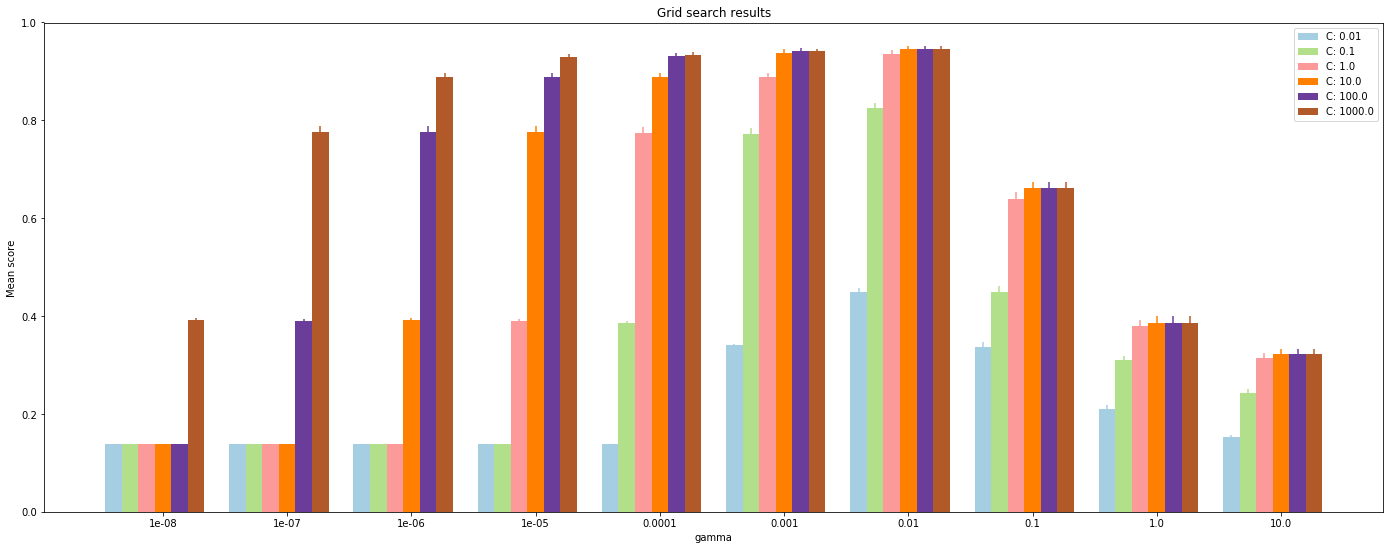

In [19]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()